In [3]:
import torch 
import gpytorch
import numpy as np
from matplotlib import pyplot as plt
import sys
import os
sys.path.append(os.path.abspath('../..'))

from pv_plot.plotting import plot_gp_ax, plot_train_test_split
from data import PVWeatherGenerator, SystemLoader

from models import ApproximateGPBaseModel
from likelihoods.beta import BetaLikelihood_MeanParametrization
from kernels import Kernel

## Weather Data

In [4]:
DAY_INIT = 0 # start of data is 01-01-2018
N_DAYS = 365 # data until 01-01-2019
DAY_MIN = 8 # starting hour of all our data (per day)
DAY_MAX = 16 # ending hour of all our data (per day)
MINUTE_INTERVAL = 5 # the minute interval of our data
DAILY_DATA_POINTS = (DAY_MAX - DAY_MIN) * 60 // MINUTE_INTERVAL
N_DAYS_FOLD = 7
N_SYSTEMS = 6
CIRCLE_COORDS = (53.28, -3.05)
RADIUS = 0.25
interval = int(DAILY_DATA_POINTS * N_DAYS_FOLD)

In [5]:
generator = PVWeatherGenerator(
    coords=CIRCLE_COORDS,
    radius=RADIUS,
    day_init=DAY_INIT,
    n_systems=N_SYSTEMS,
    n_days=N_DAYS,
    minute_interval=MINUTE_INTERVAL,
)
loader = SystemLoader(generator.df, train_interval=interval)
df = generator.df

==> Loading data


==> Loaded data in: 0 m : 45 sec



In [6]:
df = generator.df

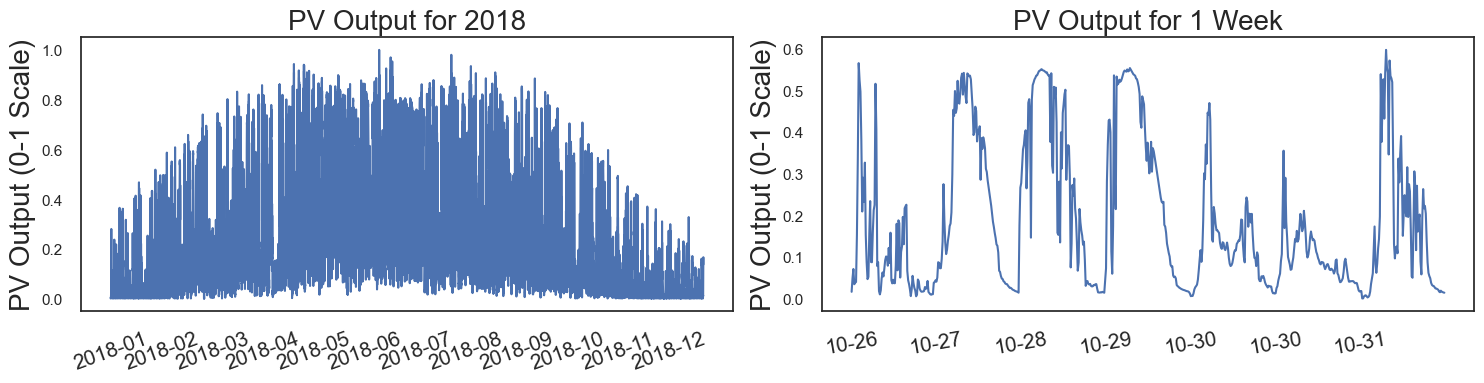

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have defined DAILY_DATA_POINTS and generator.df earlier

day = 300
plt.rcParams['font.family'] = 'Arial'
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
df['PV'][:365*DAILY_DATA_POINTS].plot(ax=ax[0])
df['PV'][day*DAILY_DATA_POINTS:(day + 7)*DAILY_DATA_POINTS].plot(ax=ax[1])

index = df.index
index = pd.to_datetime(index)
index_year_month = index.strftime('%Y-%m')
index_day_hour = index.strftime('%m-%d')

tick_positions_1 = range(0, len(index_year_month[:365*DAILY_DATA_POINTS]), 3000)  # Adjust 100 as needed
tick_labels_1 = index_year_month[:365*DAILY_DATA_POINTS:3000]

tick_positions_2 = range(0, len(index_day_hour[day*DAILY_DATA_POINTS:(day + 7)*DAILY_DATA_POINTS]), 96)  # Adjust 100 as needed
tick_labels_2 = index_day_hour[day*DAILY_DATA_POINTS:(day + 7)*DAILY_DATA_POINTS:96]

ax[0].set_xticks(tick_positions_1)
ax[0].set_xticklabels(tick_labels_1, rotation=20, fontsize=15)

ax[1].set_xticks(tick_positions_2)
ax[1].set_xticklabels(tick_labels_2, rotation=10, fontsize=15)

ax[0].set_ylabel('PV Output (0-1 Scale)', fontsize=20)
ax[1].set_ylabel('PV Output (0-1 Scale)', fontsize=20)
ax[0].set_title('PV Output for 2018', fontsize=20)
ax[1].set_title('PV Output for 1 Week', fontsize=20)

ax[0].set_xlabel('')
ax[1].set_xlabel('')
plt.tight_layout()  # Ensures the subplots are properly arranged
plt.show()



In [8]:
# drop month season latitude, longitude 
df = df.drop(['month', 'latitude', 'longitude'], axis=1)

In [9]:
df.columns

Index(['PV', 'season', 't_2m:C', 'relative_humidity_2m:p', 'wind_speed_10m:ms',
       'diffuse_rad:W', 'global_rad:W', 'effective_cloud_cover:octas'],
      dtype='object')

In [10]:
# rename columns
df = df.rename(columns={'t_2m:C' : 'Temp', 
'relative_humidity_2m:p' : 'Humidity',
'wind_speed_10m:ms' : 'Wind',
'diffuse_rad:W' : 'Diffuse Rad',
'global_rad:W' : 'Global Rad',
'effective_cloud_cover:octas' : 'Cloud Cover',
'season' : 'Season',
})



In [11]:
df.loc[df['Season'] == 'fall', 'Season'] = 'Autumn'
df.loc[df['Season'] == 'winter', 'Season'] = 'Winter'
df.loc[df['Season'] == 'spring', 'Season'] = 'Spring'
df.loc[df['Season'] == 'summer', 'Season'] = 'Summer'


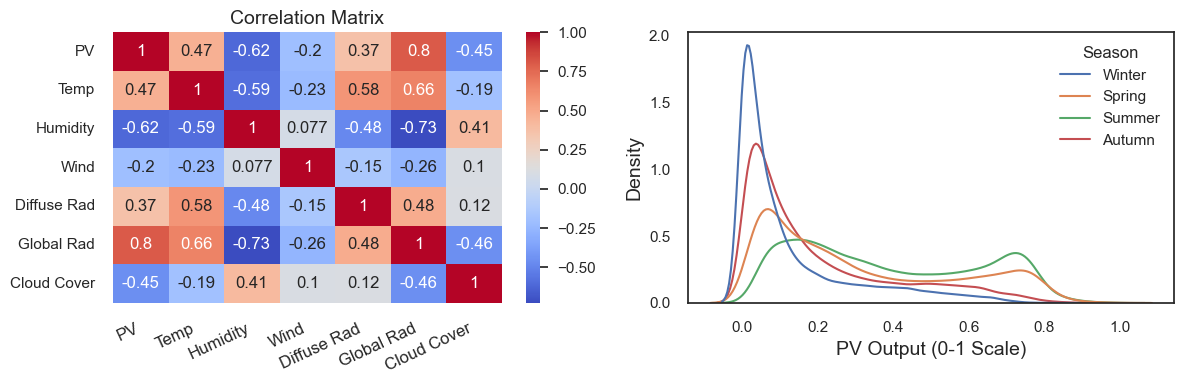

In [12]:
# plot correlation matrix and distribution of each variable wrt season
import seaborn as sns
plt.rcParams['font.family'] = 'Arial'
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
df_1 = df.drop(['Season'], axis=1)
# create correlation matrix where bottom labels are rotated by 45 degrees
sns.heatmap(df_1.corr(), annot=True, ax=ax[0], cmap='coolwarm', xticklabels=True, yticklabels=True)
ax[0].set_title('Correlation Matrix', fontsize=14)
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=25, horizontalalignment='right', fontsize=12)

# plot kde of each variable with hue as season using seaborn
sns.kdeplot(data=df, x='PV', hue='Season', ax=ax[1])
ax[1].set_ylabel('Density', fontsize=14)
ax[1].set_xlabel('PV Output (0-1 Scale)', fontsize=14)
plt.tight_layout()

In [13]:
df['Season'].unique()

array(['Winter', 'Spring', 'Summer', 'Autumn'], dtype=object)

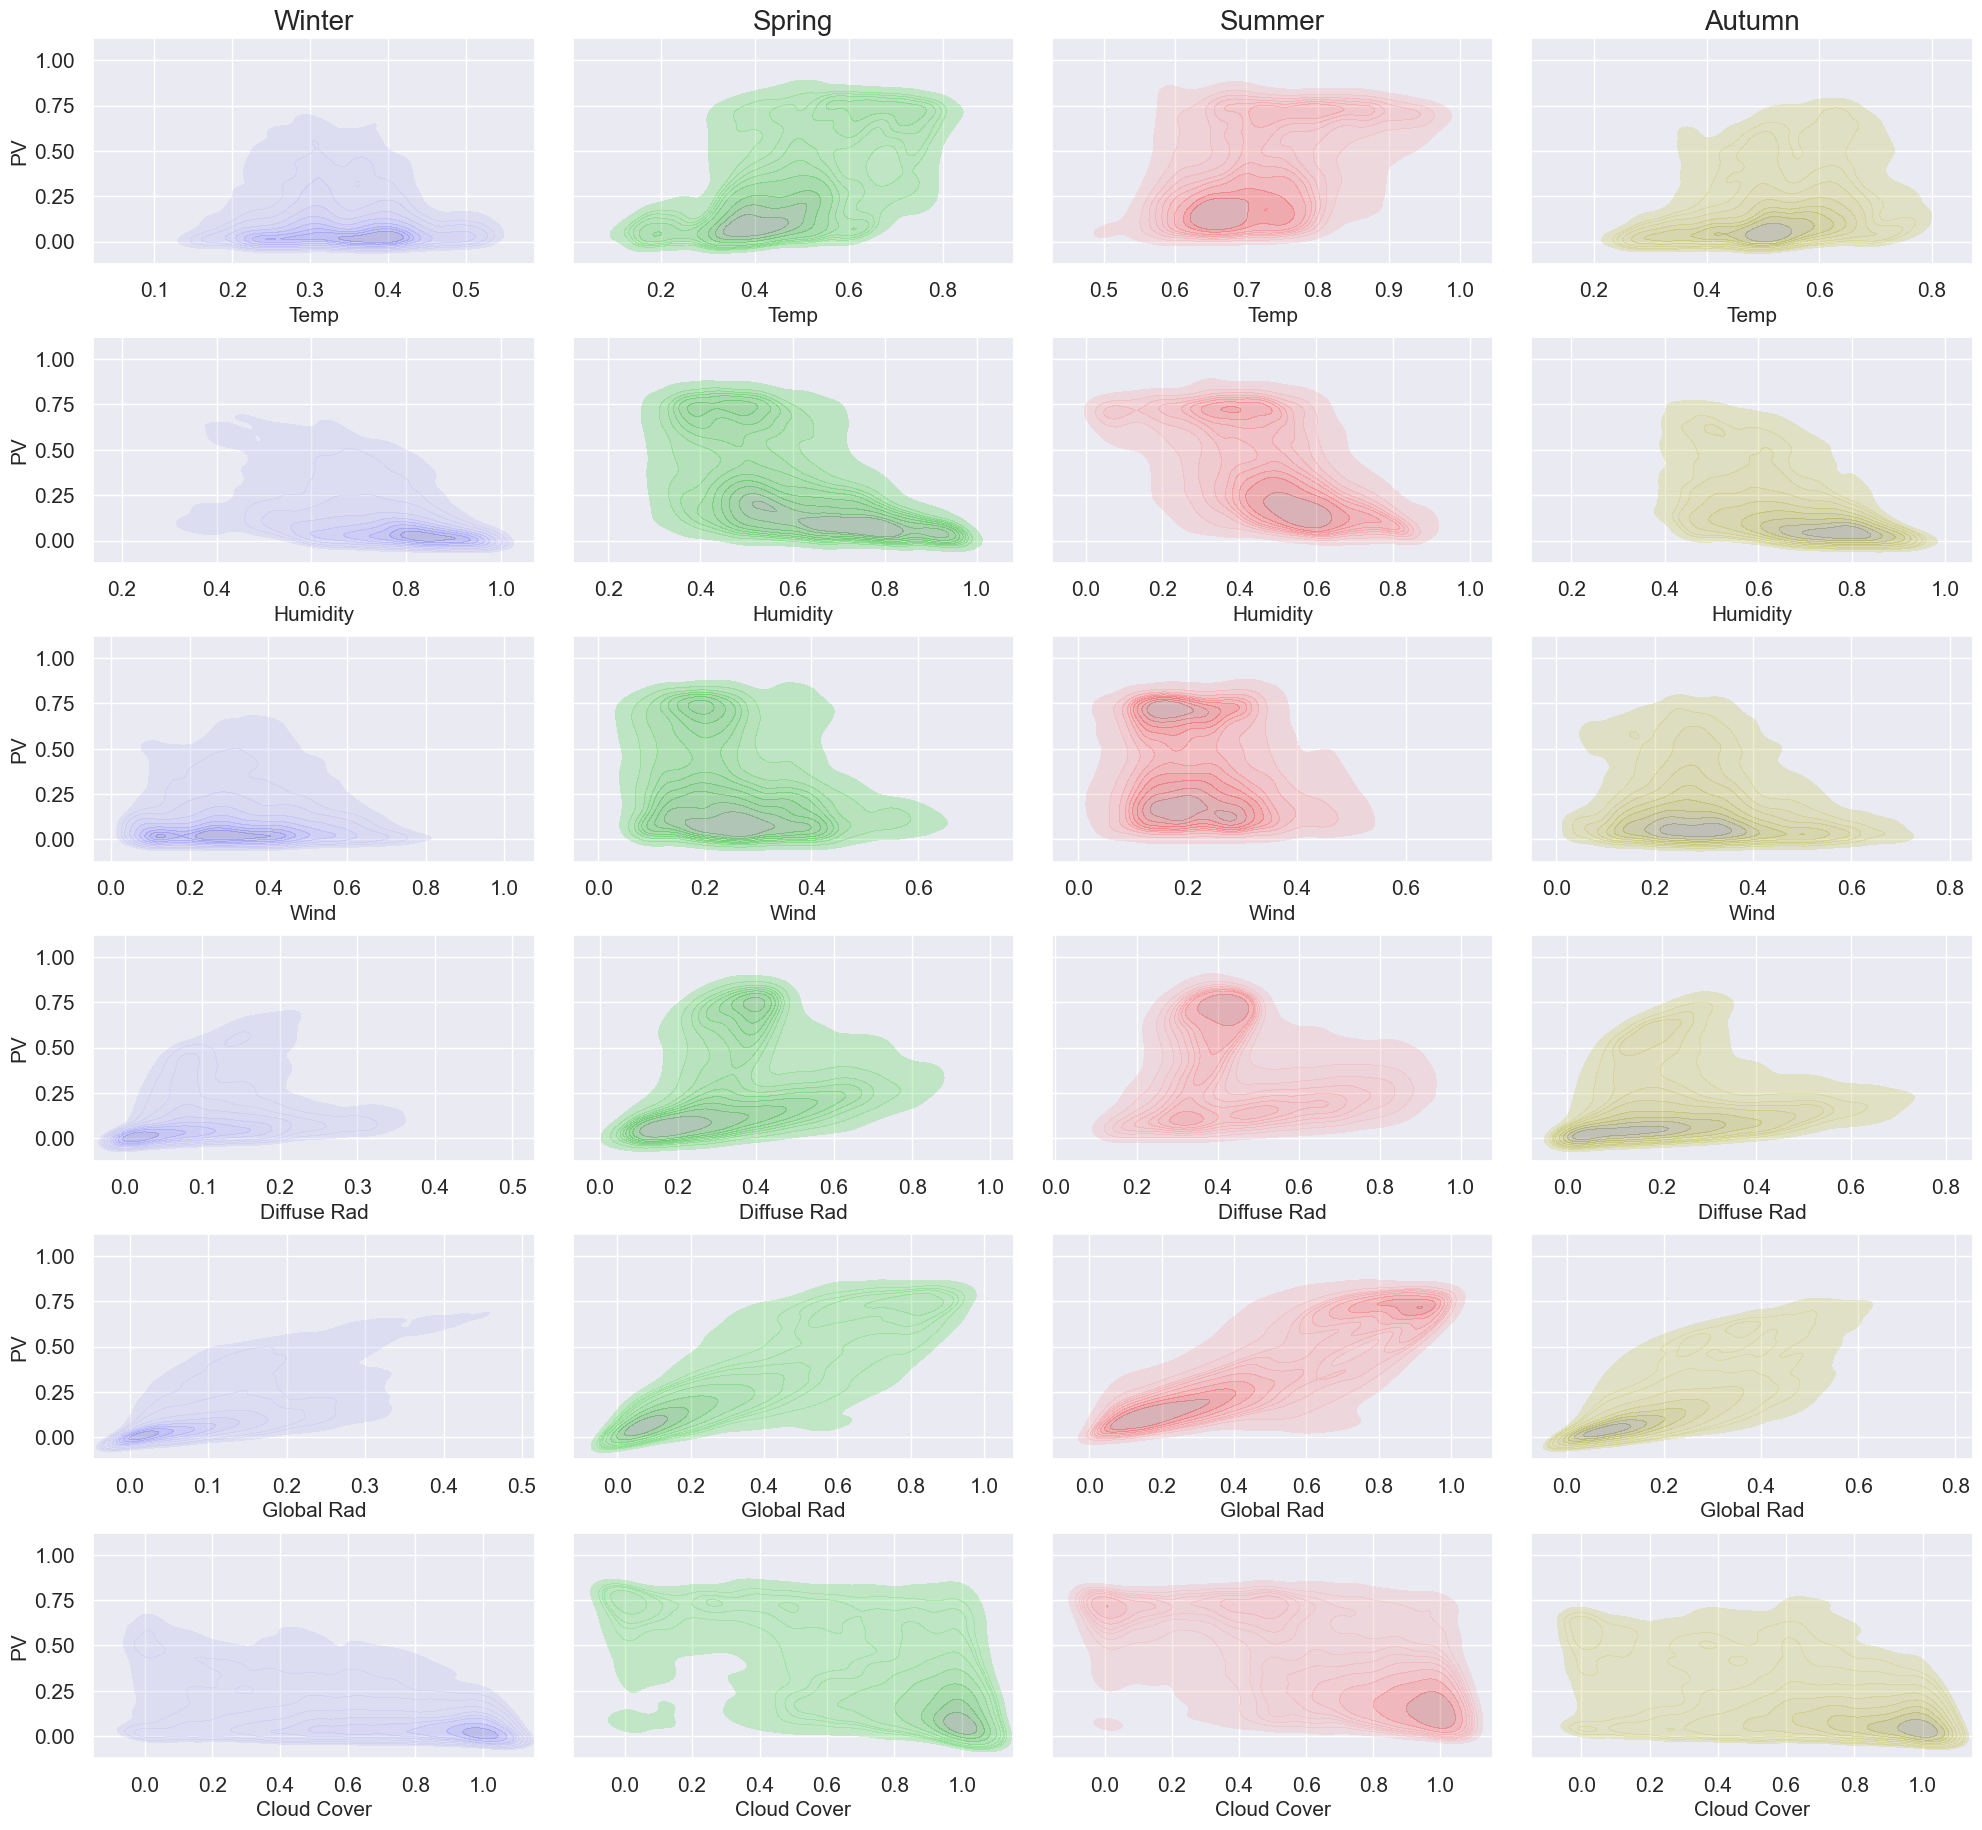

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of Seaborn
sns.set(style="darkgrid")

# Create matrix of distribution of each variable wrt season and PV values as the y-axis
plt.rcParams['font.family'] = 'Arial'
fig, ax = plt.subplots(6, 4, figsize=(20, 20), sharey=True, sharex=False)

# Define seasons and columns
seasons = df['Season'].unique()
columns = df_1.columns[1:]
# set seasonal colors, blue for winter, green for spring, red for summer, yellow for autumn
colors = ['blue', 'green', 'red', 'yellow']

for i, col in enumerate(columns):
    for j, season in enumerate(seasons):
        if col == 'Season':
            continue
        df_season = df[df['Season'] == season]

        # Create a single KDE plot where y-axis is "PV" and x-axis is the column
        sns.kdeplot(data=df_season, x=col, y='PV', common_norm=False, fill=True, alpha=0.3, ax=ax[i][j], color=colors[j])

        ax[i][j].set_xlabel(col, fontsize=15)  # Set the x-axis label as the season name
        ax[i][j].set_ylabel('PV', fontsize=15)  # Set the y-axis label for the last row
        # set font size of ytixks
        ax[i][j].tick_params(axis='both', which='major', labelsize=15)

# set title on the top row for each column
for j, season in enumerate(seasons):
    ax[0][j].set_title(season, fontsize=20)

# Adjust the layout
plt.tight_layout()
plt.subplots_adjust(top=0.9)

# Show the plot
plt.show()


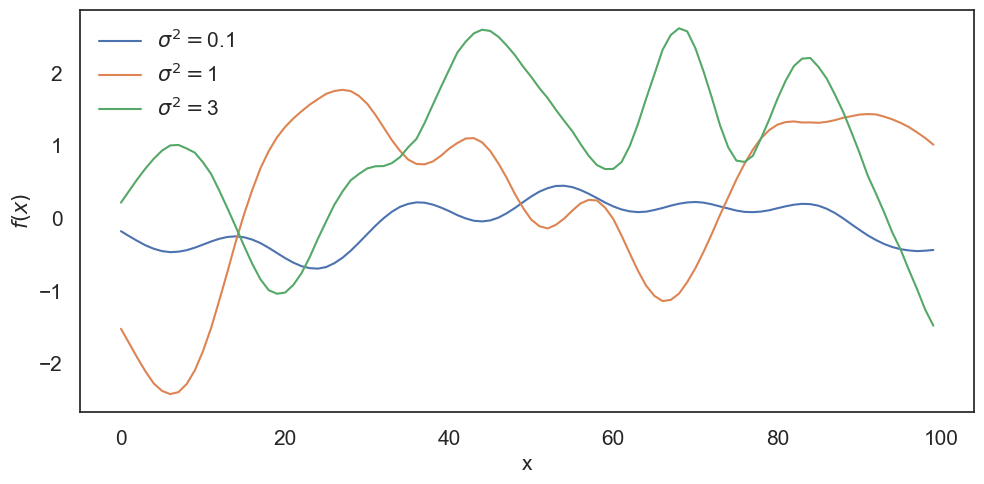

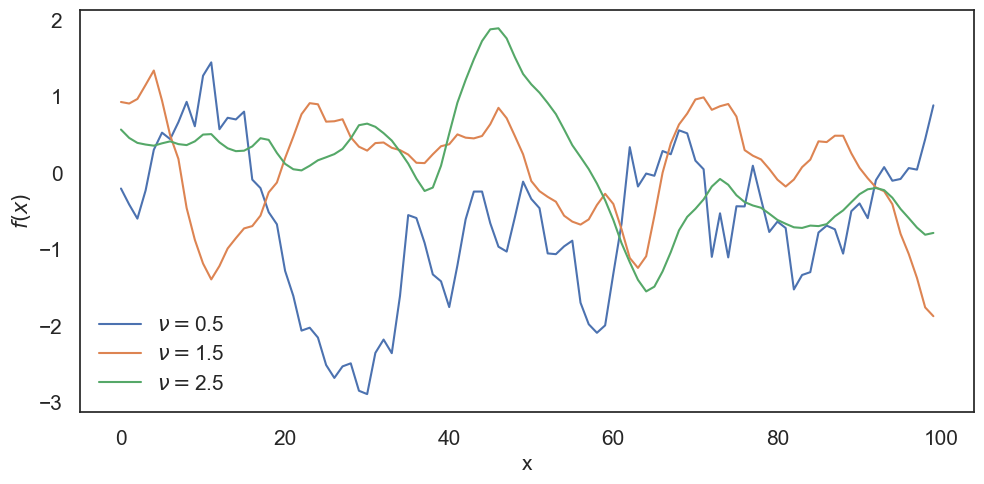

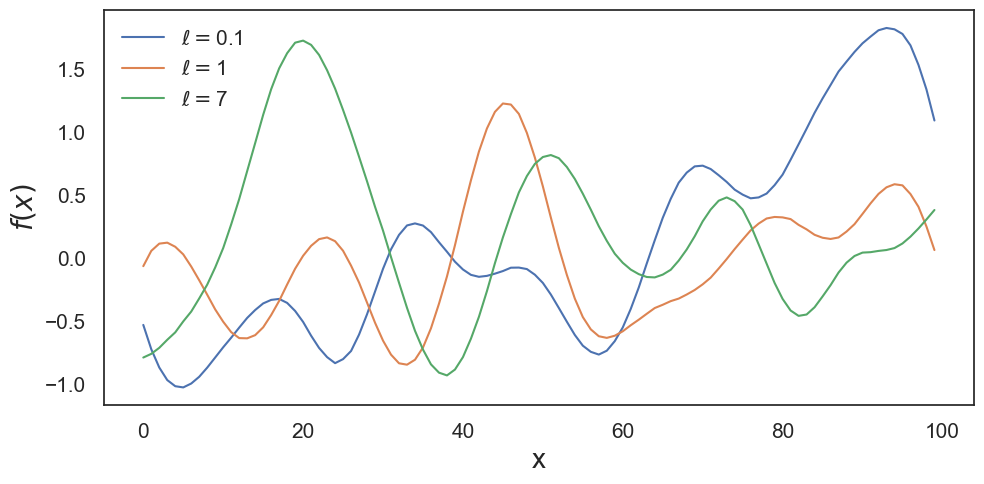

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


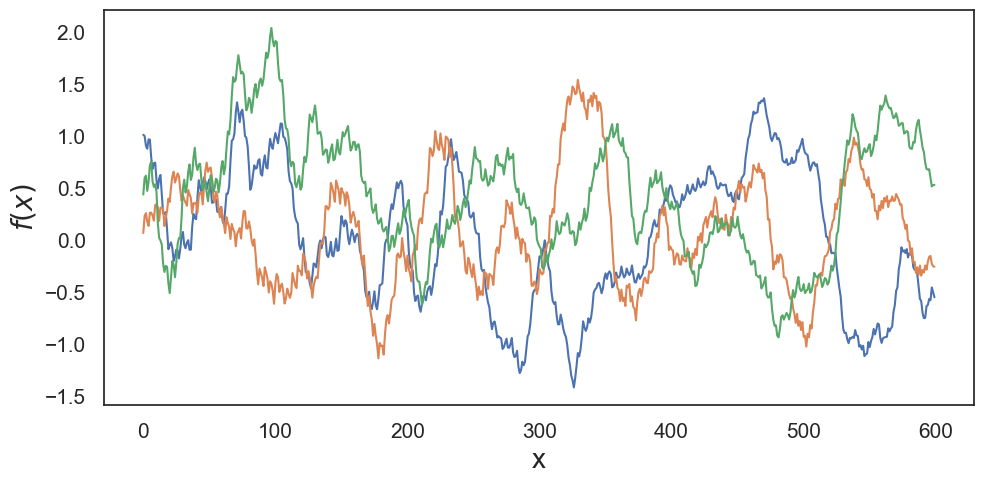

In [19]:
from kernels import get_mean_covar
import gpytorch
from matplotlib import pyplot as plt
_, quasi_periodic = get_mean_covar(num_latent=1)
m = gpytorch.means.ZeroMean()
lengtscales = [0.1, 1, 7]
nus =[1/2, 3/2, 5/2]
signal_var = [0.1, 1, 3]
# set backgroud color to default
plt.rcParams['font.family'] = 'Arial'

def plot_signal_var(mean, signal_var):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    x = torch.linspace(0, 10, 100)
    for var in signal_var:
        kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=1),
                                              outputscale_constraint=gpytorch.constraints.Positive(
                                                  initial_value=torch.tensor(var)))
        mu = mean(x)
        covar = kernel(x)
        dist = gpytorch.distributions.MultivariateNormal(mu, covar)
        samples = dist.sample()
        ax.plot(samples.numpy(), label=r'$\sigma^2 = $' + str(var))
    
    ax.legend(loc='best', fontsize=15)
    ax.set_xlabel(r"x", fontsize=15)
    ax.set_ylabel(r"$f(x)$", fontsize=15)
    ax.tick_params(axis='both', which='major', labelsize=15)
    plt.tight_layout()
    plt.savefig('signal.png')
    plt.show()

def plot_nu(mean, nu):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    x = torch.linspace(0, 10, 100)
    for n in nu:
        kernel = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=n, ard_num_dims=1))
        mu = mean(x)
        covar = kernel(x)
        dist = gpytorch.distributions.MultivariateNormal(mu, covar)
        samples = dist.sample()
        ax.plot(samples.numpy(), label=r'$\nu = $' + str(n))
    
    ax.legend(loc='best', fontsize=15)
    ax.set_xlabel(r"x", fontsize=15)
    ax.set_ylabel(r"$f(x)$", fontsize=15)
    # set ticks font size
    ax.tick_params(axis='both', which='major', labelsize=15)
    plt.tight_layout()
    plt.savefig('matern.png')
    plt.show()

def plot_lengtscales(mean, lengtscales):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    x = torch.linspace(0, 10, 100)
    for l in lengtscales:
        kernel = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(lengthscale=torch.tensor(l), ard_num_dims=1))
        mu = mean(x)
        covar = kernel(x)
        dist = gpytorch.distributions.MultivariateNormal(mu, covar)
        samples = dist.sample()
        ax.plot(samples.numpy(), label=r'$\ell = $' + str(l))

    ax.legend(loc='best', fontsize=15)
    ax.set_xlabel(r"x", fontsize=20)
    ax.set_ylabel(r"$f(x)$", fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=15)
    plt.tight_layout()
    plt.savefig('lengthscale.png')
    
    plt.show()

def plot_quasi_periodic(mean, quasi_periodic):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    x = torch.linspace(0, 100, 600)
    mu = mean(x)
    covar = quasi_periodic(x)
    dist = gpytorch.distributions.MultivariateNormal(mu, covar)
    samples = dist.sample(torch.Size([3]))
    ax.plot(samples.numpy().T)

    ax.legend(loc='best', fontsize=15)
    ax.set_xlabel(r"x", fontsize=20)
    ax.set_ylabel(r"$f(x)$", fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=15)
    plt.tight_layout()
    plt.savefig('quasiperiodic.png')
    
    plt.show()

plot_signal_var(m, signal_var)
plot_nu(m, nus)
plot_lengtscales(m, lengtscales)
plot_quasi_periodic(m, quasi_periodic)

    #




In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of Seaborn
sns.set(style="darkgrid")

# Create matrix of distribution of each variable wrt season and PV values as the y-axis
plt.rcParams['font.family'] = 'Arial'
fig, ax = plt.subplots(4, 6, figsize=(20, 6), sharey=True, sharex=True)



for i, season in enumerate(df['Season'].unique()):
    for j, col in enumerate(df_1.columns[1:]):
        if col == 'Season':
            continue
        df_season = df[df['Season'] == season]
        
        # Create a single KDE plot where y-axis is "PV" and x-axis is the column
        sns.kdeplot(data=df_season, x=col, y='PV',  common_norm=False, palette="tab10", fill=True, alpha=0.3, ax=ax[i][j])

        ax[3][j].set_xlabel(col, fontsize=15)
    # Set the label for x-axis as the column name
    ax[i][0].set_ylabel('PV Output (0-1 Scale)', fontsize=15)
    ax[i][0].set_title(season, fontsize=20)
    

    
    # Adjust the layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)

    # Show the plot
    plt.show()


In [7]:
jitter = 1e-6
gp_config = {
        'type' : 'stochastic', # SVI
        'name' : 'cholesky', # type of posterior covariance approximation
        'jitter' : jitter, # jitter for numerical stability
    }

In [ ]:
from kernels import get_mean_covar_weather
from models import ApproximateGPBaseModel
from likelihoods import BetaLikelihood_MeanParametrization


for X_tr, Y_tr, X_te, Y_te, T_tr, T_te in loader:
    fig, ax = plt.subplots(N_SYSTEMS // 2, 2, figsize=(30, 5 * (N_SYSTEMS)), sharex=True, sharey=True)
    ax = ax.flatten()
    plt.rcParams['font.serif'] = ['Times New Roman']
    
    for i in range(loader.n_systems):
        x_tr, y_tr, x_te, y_te = loader.train_test_split_individual(i)
        x_tr = x_tr[:,:-1]
        x_te = x_te[:,:-1]
        gp_config['num_inducing_points'] = x_tr.shape[0]
        mean, covar = get_mean_covar_weather(num_latents=1, d=x_tr.shape[-1], weather_kernel='matern', combine='product')

        model = ApproximateGPBaseModel(
            X=x_tr,
            y=y_tr,
            mean_module=mean,
            covar_module=covar,
            likelihood = BetaLikelihood_MeanParametrization(scale=30),
            config=gp_config,
        )
     
        model.fit(n_iter=100, lr=0.2, verbose=True)
        
        plot_gp_ax(model, x_tr, x_te, y_tr, y_te, pred_type='median', ax=ax[i])
        ax[i].set_title(f'Task {i+1}', fontsize=30)
        ax[i].legend(fontsize=25, loc='upper left')
        # set y label for left column
        if i % 2 == 0:
            ax[i].set_ylabel('PV Output (0-1 Scale)', fontsize=30)
            # add y ticks
            y_ticks_rounded = np.round(np.arange(0, 1.1, 0.2), 1)
            ax[i].set_yticklabels(y_ticks_rounded, fontsize=25)
        # set x label for bottom row
        if i >= N_SYSTEMS - 2:
            ax[i].set_xlabel('Time Steps (5 Minute Intervals)', fontsize=30)
            # add x ticks
            n_tr = x_tr.shape[0]
            n_te = x_te.shape[0]
            ax[i].set_xticklabels(np.arange(0, n_tr+n_te, 100), fontsize=25)
    
    plt.show()
    # updated slicing
    break
